In [1]:
import pandas as pd
pd.options.mode.chained_assignment=None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
import time
import sys
from sklearn.impute import KNNImputer
import random

# Preprocessing data

Load ANES dataset. We create a list of dataframes, one for every edition considered in the paper (1992, 2000, 2008, 2016, 2020).

In [2]:
data = pd.read_csv('../csvfiles/ANESdataset.csv')

yearsSubset = (1992, 2000, 2008, 2016, 2020)
dataframes = list()
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    dataframes.append(data.query("VCF0004 == @year"))
    dataframes[i] = dataframes[i].drop(columns="VCF0004")
    for col in dataframes[i]:
        dataframes[i][col] = pd.to_numeric(dataframes[i][col], errors='coerce')
    dataframes[i][dataframes[i] < 0] = np.nan

## Missing values

Missing values (don't know \[DK\], no answer \[NA\]) for every of the 41 questions considered.

In [3]:
missingValues = {
    'VCF0310':[0,9],
    'VCF0606':[0,9],
    'VCF0609':[0,9], 
    'VCF0624':[0,9],
    'VCF0733':[9],
    'VCF0806':[0,9],
    'VCF0809':[0,9],
    'VCF0830':[0,9],
    'VCF0838':[0,9],
    'VCF0839':[0,9],
    'VCF0843':[0,9],
    'VCF0850':[0,9],
    'VCF0852':[8,9],
    'VCF0853':[8,9],
    'VCF0867a':[7,8,9],
    'VCF0871':[0,8,9],
    'VCF0872':[0,8,9],
    'VCF0876a':[7,9],
    'VCF0886':[8,9],
    'VCF0888':[8,9],
    'VCF0890':[8,9],
    'VCF0894':[8,9],
    'VCF9013':[8,9],
    'VCF9016':[8,9],
    'VCF9017':[8,9],
    'VCF9018':[8,9],
    'VCF9039':[8,9],
    'VCF9040':[8,9],
    'VCF9041':[8,9],
    'VCF9042':[8,9],
    'VCF9047':[7,8,9],
    'VCF9049':[7,8,9],
    'VCF9206':[],
    'VCF9237':[],
    'VCF9246':[],
    'VCF9248':[],
    'VCF9249':[],
    'VCF9270':[],
    'VCF9271':[],
    'VCF9272':[],
    'VCF9273':[]}

len(missingValues.keys())

41

We set missing values to NaN for every question.

In [4]:
def eraseElementsDics(dataframes, dic):
    """ Set to NaN specific values for every question

    Parameters:
    dataframes -- list of dataframes
    dic -- dictionary {question: list(values to be NaN)}
    """
    
    for i in range(len(dataframes)):
        for elem in dic.keys():
            try:
                dataframes[i][elem] = dataframes[i][elem].replace(dic[elem], np.nan)
            except:
                pass

In [5]:
# Setting missing values to NaN
eraseElementsDics(dataframes, missingValues)

## List of variable changes


### VCF0609
GOVERNMENT OFFICIALS CARE WHAT PEOPLE LIKE RESPONDENT THINK has options
1. Agree
2. Disagree
3. Neither agree nor disagree (1988 and later only)

We change options so point 3 is in between.


### VCF0867a, VCF0872, VCF0876a, VCF9237

have 4 non-consecutive numerical options. We change them so all four options are consecutive.

In [6]:
for i in range(len(dataframes)):

    dataframes[i].VCF0609 = dataframes[i].VCF0609.replace([2.0,3.0],[3.0,2.0])
    
    dataframes[i].VCF0867a = dataframes[i].VCF0867a.replace([4.0,5.0],[3.0,4.0])
    dataframes[i].VCF0872 = dataframes[i].VCF0872.replace([3.0,5.0],[2.0,3.0])
    dataframes[i].VCF0876a = dataframes[i].VCF0876a.replace([4.0,5.0],[3.0,4.0])
    dataframes[i].VCF9237 = dataframes[i].VCF9237.replace([4.0,5.0],[3.0,4.0])


for i in range(len(dataframes)):
    dataframes[i] = dataframes[i].reindex(sorted(dataframes[i].columns), axis=1)

## Flipping answers

Some questions have the numerical classification inverted, where the lowest number implies maximum agreement.

In [7]:
questionsToFlip = ['VCF0606','VCF0609','VCF0806','VCF0809','VCF0830','VCF0850','VCF0852','VCF0853','VCF0867a',
                   'VCF0871','VCF0872','VCF0876a','VCF0886','VCF0888','VCF0890','VCF0894','VCF9013','VCF9016',
                   'VCF9017','VCF9018','VCF9039','VCF9040','VCF9041','VCF9042','VCF9047','VCF9049','VCF9237',
                   'VCF9270','VCF9271','VCF9272','VCF9273']

We flip the inverted answers of the selected questions.

In [8]:
def flipAnswers(DataframeList, flipQuestions):
    """ Flip the list of dataframes (numerical options) for selected questions

    Parameters:
    DataframeList -- list of dataframes
    flipQuestions -- list of questions to be flipped 
    """
    
    for i in range(len(DataframeList)):
        for column in flipQuestions:
            try:
                dataframes[i][column] = dataframes[i][column].max() + dataframes[i][column].min() - dataframes[i][column]
            except:
                pass

In [9]:
# Flipping answers
flipAnswers(dataframes, questionsToFlip)

## Question renaming

The 41 questions considered according to ANES ID codes and topics.

In [10]:
questionsResume = {
  'VCF0310': "Interest in elections",
  'VCF0606': "Federal wasted money",
  'VCF0609': "Government cares what people think",
  'VCF0624': "Elections make government pay attention",
  'VCF0733': "Frequency of political discussions",
  'VCF0806': "Government health insurance",
  'VCF0809': "Guaranteed jobs and income",
  'VCF0830': "Aid to blacks",
  'VCF0838': "Abortion allowed by law",
  'VCF0839': "Government services-spending scale",
  'VCF0843': "Defense spending scale",
  'VCF0850': "Authority of the bible",
  'VCF0852': "Should adjust view of moral behavior to changes",
  'VCF0853': "Should be more emphasis on traditional values",
  'VCF0867a':"Preference on blacks when hiring",
  'VCF0871': "Better economy than past year",
  'VCF0872': "Better economy next year",
  'VCF0876a':"Protection to homosexuals",
  'VCF0886': "Federal spending: poor people",
  'VCF0888': "Federal spending: dealing with crime",
  'VCF0890': "Federal spending: public schools",
  'VCF0894': "Federal spending: welfare programs",
  'VCF9013': "Ensure equal opportunity to succeed",
  'VCF9016': "Life unfair by default",
  'VCF9017': "Should worry less about how equal people are",
  'VCF9018': "All should be treated equally",
  'VCF9039': "Blacks have it difficult to succeed",
  'VCF9040': "Blacks should not be favored",
  'VCF9041': "Blacks must try harder",
  'VCF9042': "Blacks gotten less than deserved",
  'VCF9047': "Federal spending: environment",
  'VCF9049': "Federal spending: social security",
  'VCF9206': "Presidency and congress splitted",
  'VCF9237': "Death penalty",
  'VCF9246': "Child attribute: curiosity vs good manners",
  'VCF9248': "Child attribute: considerate vs well-behaved",
  'VCF9249': "Child attribute: independence vs respect for elders",
  'VCF9270': "Hardworking for whites",
  'VCF9271': "Hardworking for blacks",
  'VCF9272': "Hardworking for Hispanic-Americans",
  'VCF9273': "Hardworking Asian-Americans"
}

In [11]:
# Renaming questions by topics
for i in range(len(dataframes)):
    dataframes[i].rename(questionsResume,axis=1, inplace=True)

## Missing deletion and imputation

Some questions show high rates of missing values.

In [12]:
# Redefine numerical options within the interval [0,1]
for i in range(len(dataframes)):
    dataframes[i] = (dataframes[i] - dataframes[i].min())/(dataframes[i].max() - dataframes[i].min())


# Numerical ordering for each year according to the missing rate of 1992
for i in range(len(dataframes)):
    dataframes[i] = dataframes[i].reindex((dataframes[0].isna().sum()/len(dataframes[i])).sort_values(ascending=False, kind='mergesort').index, axis=1)

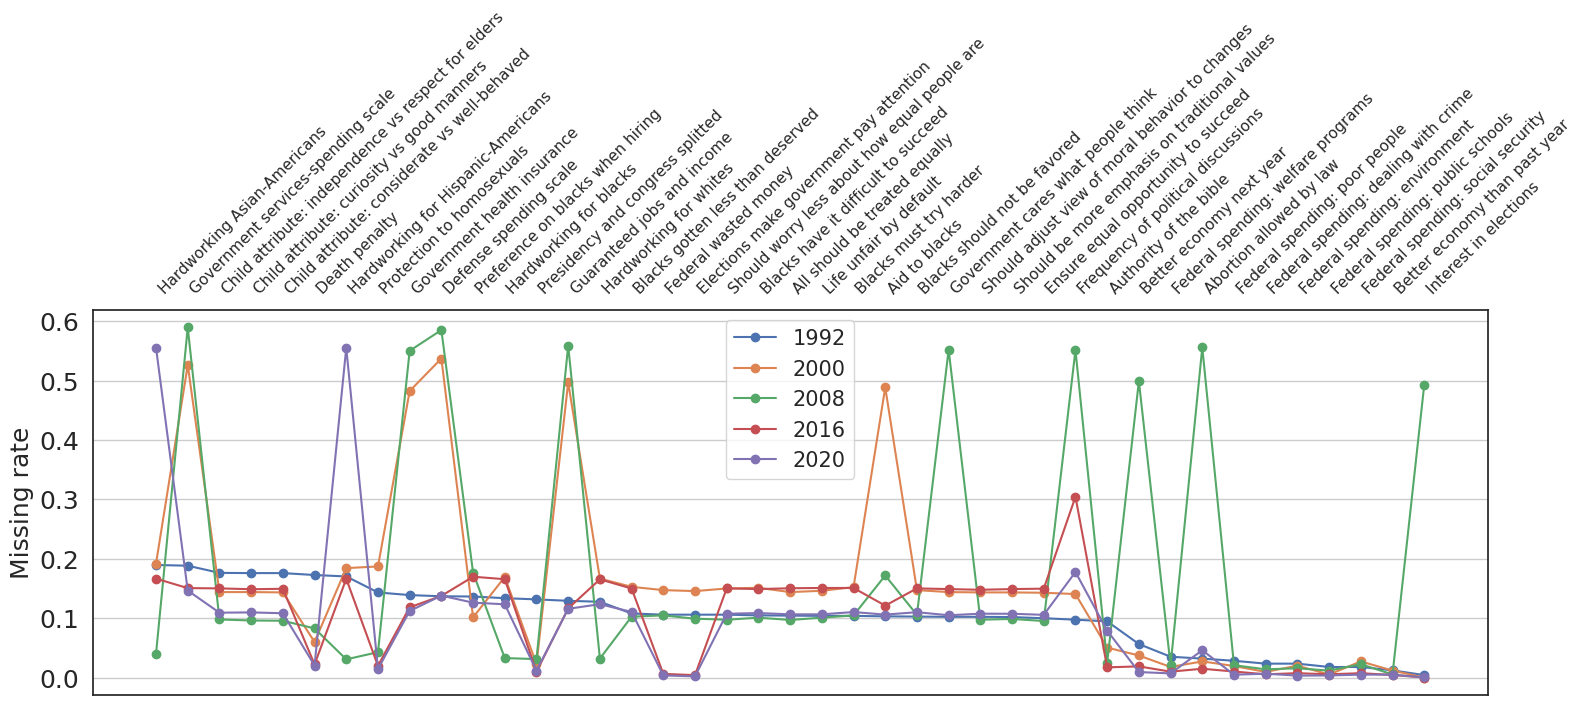

In [13]:
# Missing rates of the 41 questions considered (Supplementary Figure 2)
fig, ax = plt.subplots(figsize=(18,5))
for i in range(len(dataframes)):
    cols = dataframes[i].columns
    y = list(dataframes[i].isna().sum()/len(dataframes[i]))
    plt.tick_params(labelbottom=False, labeltop=True)
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='left')
    ax.plot(cols, y, '-o', label=str(yearsSubset[i]))
    plt.ylabel('Missing rate', fontsize=18)
    plt.yticks(fontsize=18)
plt.grid(axis='y')
plt.legend(loc='best', fontsize=15)
#plt.savefig('missing_rates.pdf', bbox_inches="tight")

We delete all questions with a missing rate greater than 20%. The number of questions considered is reduced to 29.

In [14]:
missingThreshold = 0.2
for _ in range(2):
    todrop=list()
    for i in range(len(dataframes)):
        cols = dataframes[i].columns
        rate = list(dataframes[i].isna().sum()/len(dataframes[i]))
        todrop.append([cols[rate.index(x)] for x in rate if x >= missingThreshold])
    
    todrop = np.unique(np.concatenate(todrop, axis=0))
    for i in range(len(dataframes)):
        dataframes[i].drop(todrop, axis=1, inplace=True)

len(dataframes[0].columns)

29

We impute the remaining missing values by means of the k-Nearest Neighbors (kNN) algorithm.

In [15]:
start = time.time()

sys.setrecursionlimit(100000)
cols = dataframes[0].columns

# Start the kNN training
for i in range(len(dataframes)):
    imputer = KNNImputer(n_neighbors=1, weights="uniform")
    imputed_training = imputer.fit_transform(dataframes[i])
    dataframes[i] = pd.DataFrame(imputed_training, columns=cols)


# Numerical ordering for each year according to the variance of the 1992-data
for i in range(len(dataframes)):
    dataframes[i] = dataframes[i].reindex(dataframes[0].var().sort_values(ascending=False).index, axis=1)

end = time.time()

print(f'Execution time: {round(end - start, 2)} s')

Execution time: 4.39 s


## Demographic information

We set a maximum of 2500 respondents for each ANES edition.

In [16]:
def copyDataframeArray(arr):
    """ Copy a list of dataframes by value

    Parameters:
    arr -- list of dataframes
    """
    
    result = list()
    for i in range(len(arr)):
        result.append(arr[i].copy())
    
    return result

In [17]:
dataframesReduced = copyDataframeArray(dataframes)

In [18]:
# Reducing number of respondents
tot = 2500
random.seed(9708)
todrop = list()
for i in range(len(yearsSubset)):
    NN = len(dataframesReduced[i])
    if NN <= tot:
        todrop.append(list())
    else:
        todrop.append(random.sample(range(NN), NN - tot))
    dataframesReduced[i].drop(todrop[i], inplace=True)
    # Relabel index
    index = list(dataframesReduced[i].index.values)
    relabel = {}
    for j in range(len(index)):
        relabel.update({index[j]: j})
    dataframesReduced[i].rename(index=relabel, inplace=True)

We add the respondents' attributes and groups into the collection of questions.

In [19]:
dataframesWithAttributes = copyDataframeArray(dataframesReduced)

In [20]:
demodata = pd.read_csv('../csvfiles/demographics.csv')

In [21]:
# Party
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    addGroup = demodata.query("VCF0004 == @year").VCF0303
    addGroup = pd.to_numeric(addGroup, errors='coerce')
    addGroup = list(addGroup)
    # Removing previous respondents
    for j in sorted(todrop[i], reverse=True):
        del addGroup[j]
    dataframesWithAttributes[i]["party"] = addGroup
    dataframesWithAttributes[i].party = dataframesWithAttributes[i].party.replace([0.0,1.0,2.0,3.0],["DK","Democrats","Independents","Republicans"])

# Race
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    addGroup = demodata.query("VCF0004 == @year").VCF0106
    addGroup = pd.to_numeric(addGroup, errors='coerce')
    addGroup = list(addGroup)
    # Removing previous respondents
    for j in sorted(todrop[i], reverse=True):
        del addGroup[j]
    dataframesWithAttributes[i]["race"] = addGroup
    dataframesWithAttributes[i]["race"] = dataframesWithAttributes[i]["race"].replace([1,2,3,0,9],['White','Black','DK','DK','DK'])

# Gender
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    addGroup = demodata.query("VCF0004 == @year").VCF0104
    addGroup = pd.to_numeric(addGroup, errors='coerce')
    addGroup = list(addGroup)
    # Removing previous respondents
    for j in sorted(todrop[i], reverse=True):
        del addGroup[j]
    dataframesWithAttributes[i]["gender"] = addGroup
    dataframesWithAttributes[i]["gender"] = dataframesWithAttributes[i]["gender"].replace([1,2,3],['Male','Female','DK'])

# Age
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    addGroup = demodata.query("VCF0004 == @year").VCF0102
    addGroup = pd.to_numeric(addGroup, errors='coerce')
    addGroup = list(addGroup)
    # Removing previous respondents
    for j in sorted(todrop[i], reverse=True):
        del addGroup[j]
    dataframesWithAttributes[i]["age"] = addGroup
    dataframesWithAttributes[i]["age"] = dataframesWithAttributes[i]["age"].replace([0,1,2,3,4,5,6,7],['DK','17-34', '17-34','35-54','35-54','55+','55+','55+'])

# Affluence
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    addGroup = demodata.query("VCF0004 == @year").VCF0114
    addGroup = pd.to_numeric(addGroup, errors='coerce')
    addGroup = list(addGroup)
    # Removing previous respondents
    for j in sorted(todrop[i], reverse=True):
        del addGroup[j]
    dataframesWithAttributes[i]["affluence"] = addGroup
    dataframesWithAttributes[i]["affluence"] = dataframesWithAttributes[i]["affluence"].replace([1,2,3,4,5,0],['Low-Income','Low-Income','34-66%','High-Income','High-Income','DK'])

# Education
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    addGroup = demodata.query("VCF0004 == @year").VCF0140
    addGroup = pd.to_numeric(addGroup, errors='coerce')
    addGroup = list(addGroup)
    # Removing previous respondents
    for j in sorted(todrop[i], reverse=True):
        del addGroup[j]
    dataframesWithAttributes[i]["education"] = addGroup
    dataframesWithAttributes[i]["education"] = dataframesWithAttributes[i]["education"].replace([1,2,3,4,5,6,8,9],['No-College','No-College','No-College','No-College','College','College','DK','DK'])

In [22]:
# Combining all data into a single dataframe
dfsCombined = pd.concat(dataframesWithAttributes)
dfsCombined = dfsCombined.reset_index(drop=True)

In [23]:
dfsCombined.to_csv('../csvfiles/combineddata.csv', index=False)